In [2]:
import os
import logging
import torch
import numpy as np
import copy
import os.path
import sys
import random
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torchvision.datasets import VisionDataset
from PIL import Image
import torchvision
from torchvision import transforms, datasets
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torch.autograd import Variable
from itertools import cycle
import seaborn as sns
import pandas as pd
import matplotlib as mlp

sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from model import resnet32
from seed import seed

In [15]:
class LwF(nn.Module):
  def __init__(self, n_classes, dictionary):
    super(LwF, self).__init__()

    self.model = resnet32()
    self.prev_model = None
    self.d = dictionary
    self.num_epochs = 70
    self.optimizer = optim.SGD(self.model.parameters(), lr=2, momentum=0.9, weight_decay=1e-5)
    self.scheduler = optim.lr_scheduler.MultiStepLR(self.optimizer,[49,63], gamma=0.2)
    self.criterion = nn.BCEWithLogitsLoss()

    self.n_classes = n_classes
    self.bs = n_classes

  def update_model(self):
    self.prev_model = copy.deepcopy(self.model)
    self.model.fc = nn.Linear(64, self.n_classes + self.bs)
    self.model.fc.weight.data[0: self.n_classes] = self.prev_model.fc.weight.data
    self.model.fc.bias.data[0: self.n_classes] = self.prev_model.fc.bias.data

  def forward(self, x):
    x = self.model(x) 
    return x

  def train_model(self, dataloader):
    loss_array = []
    self.model = self.model.cuda()
    cudnn.benchmark
    
    start = time.time()
    optimizer = self.optimizer
    scheduler = self.scheduler
    
    for epoch in range(self.num_epochs):
        print('Epoch {}/{}'.format(epoch+1, self.num_epochs))
        print('-' * 10)

        self.model.train() 
        
        running_loss = 0.0
        running_corrects = 0
        for images, labels in dataloader:
            
              labels_map = [d[label.item()] for label in labels]         
              labels_map = torch.as_tensor(labels_map)            
              images = images.cuda()
              labels_map = labels_map.cuda()           
              optimizer.zero_grad()
              if self.prev_model == None:              
                outputs = self.model(images)
                one_hot = nn.functional.one_hot(labels_map, self.n_classes)
                one_hot = one_hot.type_as(outputs)       
                _, preds = torch.max(outputs.data, 1)
                loss = self.criterion(outputs, one_hot)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels_map.data).data.item()
              else:
                outputs = self.model(images)                     
                self.prev_model.train(False)
                old_outputs = self.prev_model(images)
                one_hot = nn.functional.one_hot(labels_map, self.n_classes + self.bs)
                one_hot = one_hot.type_as(outputs)

                _, preds = torch.max(outputs.data, 1)
                _, old_preds = torch.max(old_outputs.data,1)
                old_outputs = torch.sigmoid(old_outputs)

                targets = torch.cat((old_outputs, one_hot[:,self.n_classes-self.bs:self.n_classes]),1)
                loss = self.criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels_map.data).data.item() #accuracy on new classes 

        del images, labels
        torch.cuda.empty_cache()

        epoch_loss = running_loss / float(len(dataloader.dataset))
        epoch_acc = running_corrects/ float(len(dataloader.dataset))
        loss_array.append(epoch_loss)
        scheduler.step()

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        print()

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

  def test_model(self,dataloader):
    self.model = self.model.cuda() 
    
    self.model.train(False)
    running_corrects = 0
    corrects = []
    predictions = []

    for images, labels in dataloader:

        labels_map = [d[label.item()] for label in labels]     
        labels_map = torch.as_tensor(labels_map)
        images = images.cuda()
        labels_map = labels_map.cuda()

        outputs = self.model(images)
        _, preds = torch.max(outputs.data, 1)    
        running_corrects += torch.sum(preds == labels_map.data).data.item()
        
        for lab,pred in zip(labels_map, preds):
          corrects.append(lab.item())
          predictions.append(pred.item())

    accuracy = running_corrects / float(len(dataloader.dataset))   
    confmat = confusion_matrix(corrects, predictions)
    print_confusion_matrix(confmat, set(corrects))
    torch.cuda.empty_cache()
    plt.show()
    
    print('Test Accuracy: {}'.format(accuracy))
    return accuracy
    


In [13]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (6,4), fontsize=5):
      df_cm = pd.DataFrame(
          confusion_matrix, index=class_names, columns=class_names, 
      )
      fig = plt.figure(figsize=figsize)
      try:
          cmap = plt.get_cmap('jet')
          new_cmap = truncate_colormap(cmap, 0.05, 0.85)
          heatmap = sns.heatmap(df_cm, annot=False, fmt="d", cmap = new_cmap)
      except ValueError:
          raise ValueError("Confusion matrix values must be integers.")
      heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
      heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
      return fig
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
      new_cmap = mlp.colors.LinearSegmentedColormap.from_list(
          'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
          cmap(np.linspace(minval, maxval, n)))
      return new_cmap

In [6]:
import random 
train_transform=transforms.Compose([
            transforms.RandomCrop(32,padding = 4),
            transforms.RandomHorizontalFlip(p=0.5),         
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=train_transform)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=test_transform)

Extracting ./data/cifar-100-python.tar.gz to ./data

Files already downloaded and verified


In [7]:
d = {seed[i]:i for i in range(len(seed))}

#creating the batches of data for different groups of 10 classes
batches_train = []
batches_test = []

for i in range(10,110,10):
  x = seed[i-10:i]
  y = seed[0:i]
  idx_train = [i for i,el in enumerate(trainset.targets) if el in x]
  batches_train.append(Subset(trainset,idx_train))
  idx_test = [j for j, el in enumerate(testset.targets) if el in y]
  batches_test.append(Subset(testset, idx_test))


train_dataloaders = [DataLoader(batch, batch_size=128, shuffle=False, num_workers=4) for batch in batches_train]
test_dataloaders = [DataLoader(batch, batch_size=128, shuffle=True, num_workers=4) for batch in batches_test]


Number of classes: 10
Epoch 1/10
----------
Loss: 0.3947 Acc: 0.1264

Epoch 2/10
----------
Loss: 0.3200 Acc: 0.1532

Epoch 3/10
----------
Loss: 0.3080 Acc: 0.1916

Epoch 4/10
----------
Loss: 0.3021 Acc: 0.2144

Epoch 5/10
----------
Loss: 0.2957 Acc: 0.2408

Epoch 6/10
----------
Loss: 0.2927 Acc: 0.2460

Epoch 7/10
----------
Loss: 0.2915 Acc: 0.2510

Epoch 8/10
----------
Loss: 0.2894 Acc: 0.2578

Epoch 9/10
----------
Loss: 0.2896 Acc: 0.2584

Epoch 10/10
----------
Loss: 0.2861 Acc: 0.2722

Training complete in 0m 53s


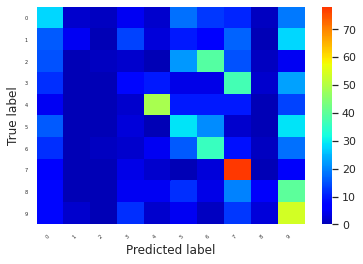

Test Accuracy: 0.294
Number of classes: 20
Epoch 1/10
----------
Loss: 0.4971 Acc: 0.0958

Epoch 2/10
----------
Loss: 0.4934 Acc: 0.1050

Epoch 3/10
----------
Loss: 0.4929 Acc: 0.0958

Epoch 4/10
----------
Loss: 0.4927 Acc: 0.0962

Epoch 5/10
----------
Loss: 0.4925 Acc: 0.0974

Epoch 6/10
----------
Loss: 0.4924 Acc: 0.0994

Epoch 7/10
----------
Loss: 0.4923 Acc: 0.1010

Epoch 8/10
----------
Loss: 0.4921 Acc: 0.1026

Epoch 9/10
----------
Loss: 0.4918 Acc: 0.1104

Epoch 10/10
----------
Loss: 0.4915 Acc: 0.1120

Training complete in 1m 38s


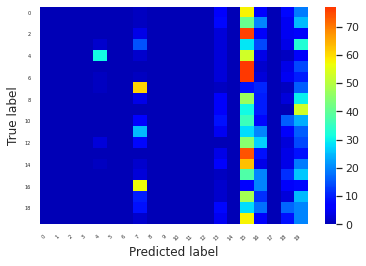

Test Accuracy: 0.0955
Number of classes: 30
Epoch 1/10
----------
Loss: 0.5519 Acc: 0.0218

Epoch 2/10
----------
Loss: 0.5452 Acc: 0.0018

Epoch 3/10
----------
Loss: 0.5443 Acc: 0.0064

Epoch 4/10
----------
Loss: 0.5441 Acc: 0.0060

Epoch 5/10
----------
Loss: 0.5438 Acc: 0.0048

Epoch 6/10
----------
Loss: 0.5435 Acc: 0.0030

Epoch 7/10
----------
Loss: 0.5434 Acc: 0.0034

Epoch 8/10
----------
Loss: 0.5433 Acc: 0.0036

Epoch 9/10
----------
Loss: 0.5432 Acc: 0.0026

Epoch 10/10
----------
Loss: 0.5432 Acc: 0.0020

Training complete in 1m 37s


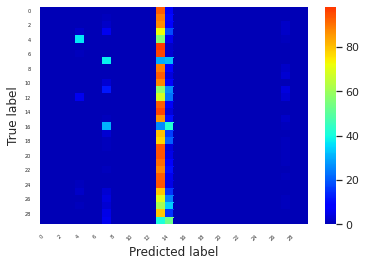

Test Accuracy: 0.057666666666666665
Number of classes: 40
Epoch 1/10
----------
Loss: 0.5779 Acc: 0.0510

Epoch 2/10
----------
Loss: 0.5751 Acc: 0.0512

Epoch 3/10
----------
Loss: 0.5706 Acc: 0.0048

Epoch 4/10
----------
Loss: 0.5669 Acc: 0.0000

Epoch 5/10
----------


KeyboardInterrupt: ignored

In [16]:
cum_acc = np.zeros(10)
#initialize the class Learning without Forgetting
lwf = LwF(10,d)

for batch,classes in enumerate(range(10,110,10)):

  lwf.n_classes = classes
  print(f'Number of classes: {classes}')
  lwf.train_model(train_dataloaders[batch])
  acc = lwf.test_model(test_dataloaders[batch])
  cum_acc[batch] = acc
  lwf.update_model()

